# QVI Retail Data Analysis

## Introduction
This notebook aims to analyze the QVI retail transaction and customer behavior data to gain insights into customer purchasing patterns and behavior. The analysis includes data cleaning, exploratory data analysis (EDA), and statistical testing.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Load transaction data
transaction_data = pd.read_csv('/kaggle/input/qvi-retail-data-comprehensive-insights/QVI_transaction_data.csv')

# Load purchase behavior data
purchase_behavior = pd.read_csv('/kaggle/input/qvi-retail-data-comprehensive-insights/QVI_purchase_behaviour.csv')

In [5]:
transaction_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [8]:
purchase_behavior.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


 # The code below include:
  
1. Removing "Salsa" Products
2. Remove transactions with unrealistic quantities (e.g., 200 packets)
3. Extract pack size from PROD_NAME
4. Extract brand name from PROD_NAME
5. Clean brand names (e.g., combine "RED" and "RRD")
6. Merge transaction and customer data


In [10]:
transaction_data["SALSA"] = transaction_data["PROD_NAME"].str.contains("salsa", case=False)
transaction_data = transaction_data[~transaction_data["SALSA"]].drop(columns=["SALSA"])
transaction_data = transaction_data[transaction_data["PROD_QTY"] < 200]
transaction_data["PACK_SIZE"] = transaction_data["PROD_NAME"].str.extract(r"(\d+)").astype(float)
transaction_data["BRAND"] = transaction_data["PROD_NAME"].str.split().str[0]
transaction_data["BRAND"] = transaction_data["BRAND"].replace({"RED": "RRD"})
print(transaction_data.head())
merged_data = pd.merge(transaction_data, purchase_behavior, on="LYLTY_CARD_NBR", how="left")
segment_sales = merged_data.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["TOT_SALES"].sum().reset_index()

    DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
0  43390          1            1000       1         5   
1  43599          1            1307     348        66   
2  43605          1            1343     383        61   
3  43329          2            2373     974        69   
4  43330          2            2426    1038       108   

                                  PROD_NAME  PROD_QTY  TOT_SALES  PACK_SIZE  \
0    Natural Chip        Compny SeaSalt175g         2        6.0      175.0   
1                  CCs Nacho Cheese    175g         3        6.3      175.0   
2    Smiths Crinkle Cut  Chips Chicken 170g         2        2.9      170.0   
3    Smiths Chip Thinly  S/Cream&Onion 175g         5       15.0      175.0   
4  Kettle Tortilla ChpsHny&Jlpno Chili 150g         3       13.8      150.0   

     BRAND  
0  Natural  
1      CCs  
2   Smiths  
3   Smiths  
4   Kettle  


## Analysis and Results
We conducted various analyses to derive insights from the data:
- **Customer Segmentation**: Identified different customer segments based on purchasing patterns.
- **Sales Trends**: Analyzed sales trends over time to identify peak periods.
- **Statistical Testing**: Performed t-tests to compare means between different customer groups.

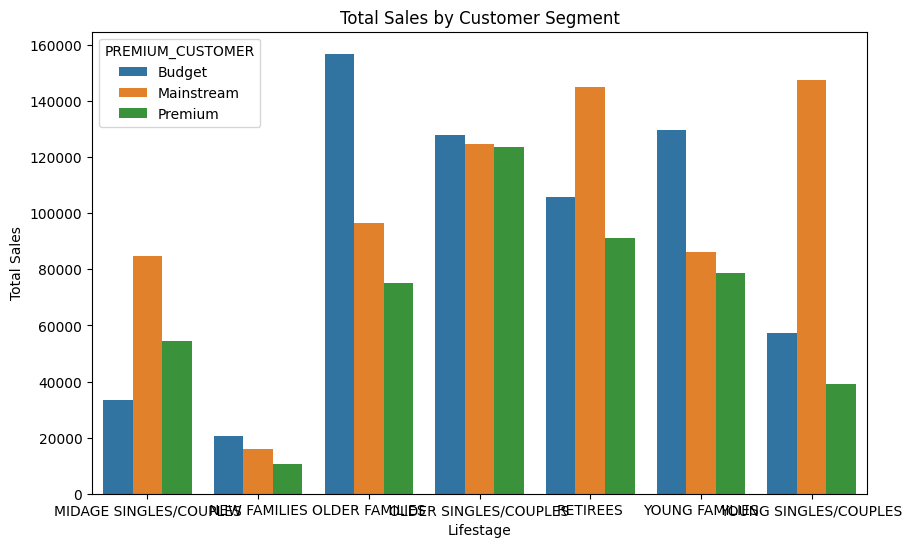

In [11]:
# Calculate total sales by LIFESTAGE and PREMIUM_CUSTOMER
segment_sales = merged_data.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["TOT_SALES"].sum().reset_index()

# Plot total sales by segment
plt.figure(figsize=(10, 6))
sns.barplot(data=segment_sales, x="LIFESTAGE", y="TOT_SALES", hue="PREMIUM_CUSTOMER")
plt.title("Total Sales by Customer Segment")
plt.xlabel("Lifestage")
plt.ylabel("Total Sales")
plt.show()

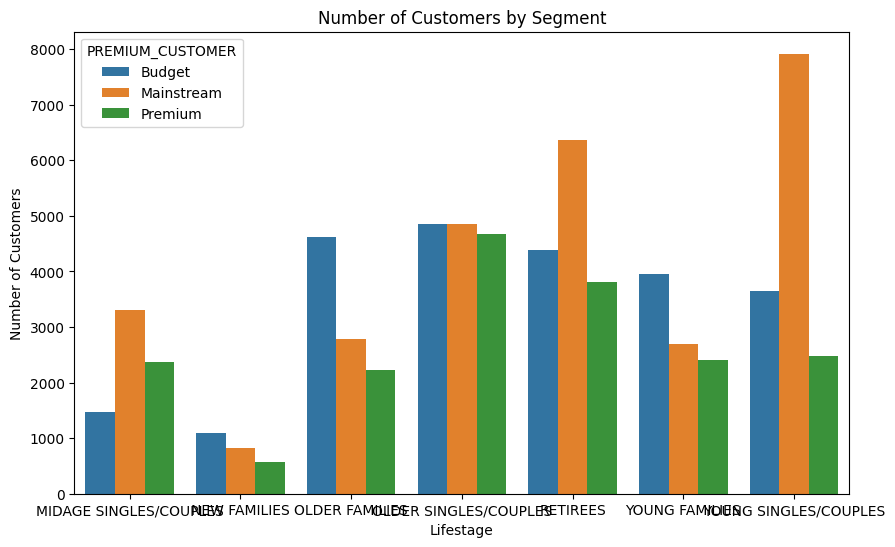

In [12]:
# Calculate number of customers by segment
segment_customers = merged_data.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["LYLTY_CARD_NBR"].nunique().reset_index()

# Plot number of customers by segment
plt.figure(figsize=(10, 6))
sns.barplot(data=segment_customers, x="LIFESTAGE", y="LYLTY_CARD_NBR", hue="PREMIUM_CUSTOMER")
plt.title("Number of Customers by Segment")
plt.xlabel("Lifestage")
plt.ylabel("Number of Customers")
plt.show()

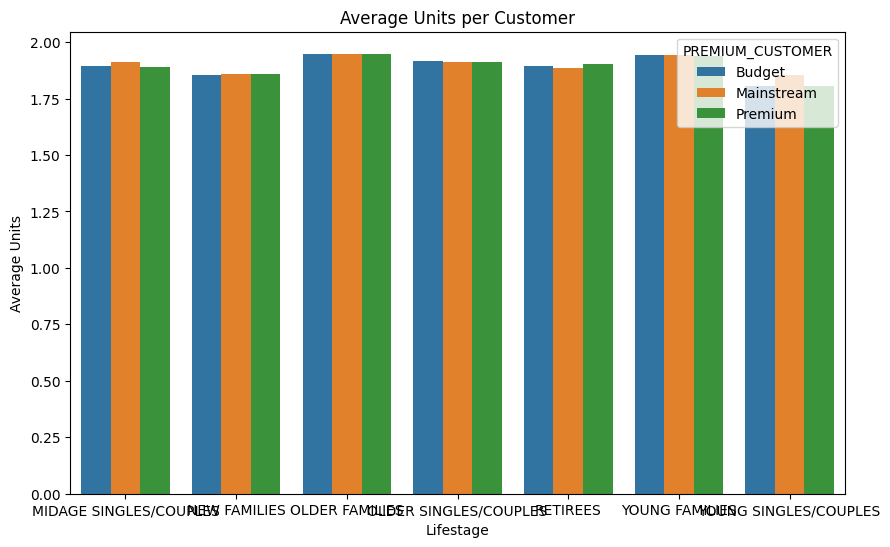

In [13]:
# Calculate average units per customer
avg_units = merged_data.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["PROD_QTY"].mean().reset_index()

# Plot average units per customer
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_units, x="LIFESTAGE", y="PROD_QTY", hue="PREMIUM_CUSTOMER")
plt.title("Average Units per Customer")
plt.xlabel("Lifestage")
plt.ylabel("Average Units")
plt.show()

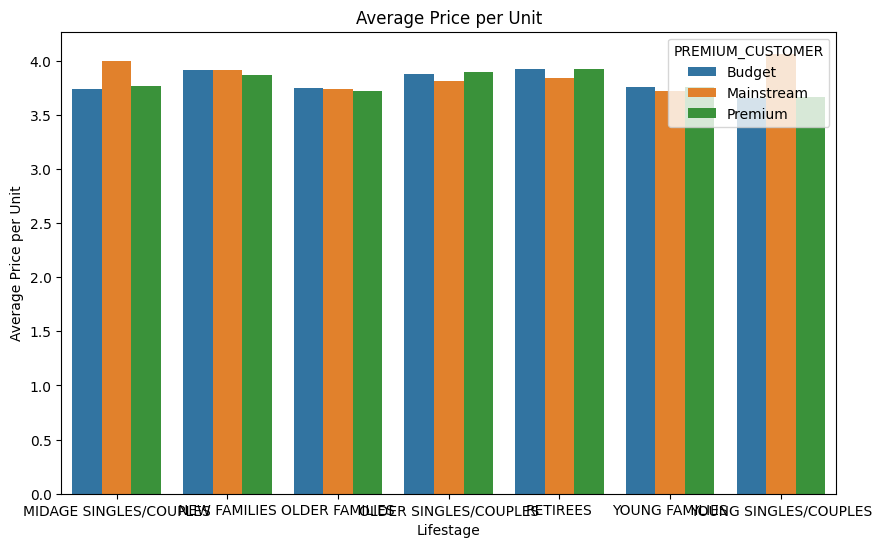

In [17]:
# Calculate average price per unit
merged_data["PRICE_PER_UNIT"] = merged_data["TOT_SALES"] / merged_data["PROD_QTY"]
avg_price = merged_data.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["PRICE_PER_UNIT"].mean().reset_index()

# Plot average price per unit
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_price, x="LIFESTAGE", y="PRICE_PER_UNIT", hue="PREMIUM_CUSTOMER")
plt.title("Average Price per Unit")
plt.xlabel("Lifestage")
plt.ylabel("Average Price per Unit")
plt.show()

In [18]:
# Compare mainstream vs. premium/budget for young singles/couples
mainstream = merged_data[(merged_data["PREMIUM_CUSTOMER"] == "Mainstream") & 
                         (merged_data["LIFESTAGE"].isin(["YOUNG SINGLES/COUPLES", "MIDAGE SINGLES/COUPLES"]))]["PRICE_PER_UNIT"]
premium_budget = merged_data[(merged_data["PREMIUM_CUSTOMER"].isin(["Premium", "Budget"])) & 
                             (merged_data["LIFESTAGE"].isin(["YOUNG SINGLES/COUPLES", "MIDAGE SINGLES/COUPLES"]))]["PRICE_PER_UNIT"]

# Perform t-test
t_stat, p_value = ttest_ind(mainstream, premium_budget)
print(f"T-Test Results: t-statistic = {t_stat}, p-value = {p_value}")

T-Test Results: t-statistic = 37.83196107667825, p-value = 2.235645611540966e-309


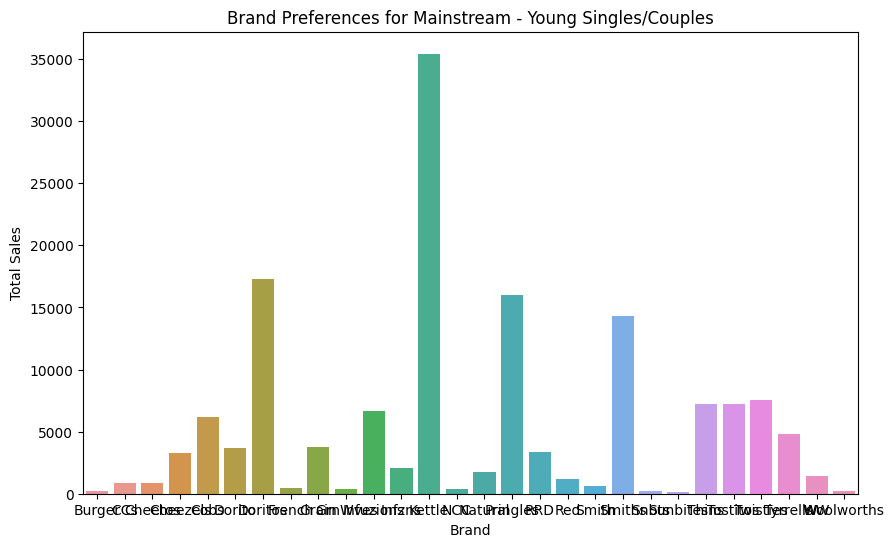

In [19]:
# Analyze brand preferences for Mainstream - Young Singles/Couples
target_segment = merged_data[(merged_data["LIFESTAGE"] == "YOUNG SINGLES/COUPLES") & 
                             (merged_data["PREMIUM_CUSTOMER"] == "Mainstream")]
brand_preferences = target_segment.groupby("BRAND")["TOT_SALES"].sum().reset_index()

# Plot brand preferences
plt.figure(figsize=(10, 6))
sns.barplot(data=brand_preferences, x="BRAND", y="TOT_SALES")
plt.title("Brand Preferences for Mainstream - Young Singles/Couples")
plt.xlabel("Brand")
plt.ylabel("Total Sales")
plt.show()

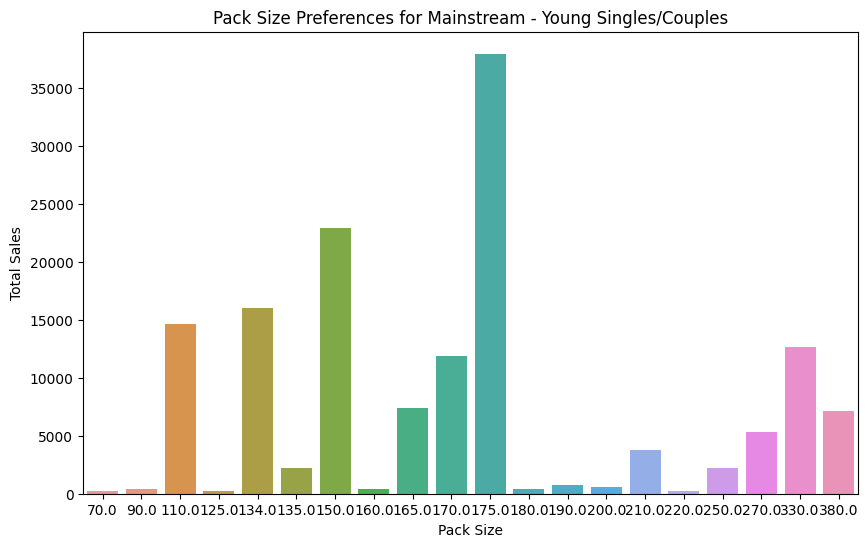

In [20]:
# Analyze pack size preferences
pack_size_preferences = target_segment.groupby("PACK_SIZE")["TOT_SALES"].sum().reset_index()

# Plot pack size preferences
plt.figure(figsize=(10, 6))
sns.barplot(data=pack_size_preferences, x="PACK_SIZE", y="TOT_SALES")
plt.title("Pack Size Preferences for Mainstream - Young Singles/Couples")
plt.xlabel("Pack Size")
plt.ylabel("Total Sales")
plt.show()

In [21]:
import os
# Save the cleaned and merged data
merged_data.to_csv("QVI_data_cleaned.csv", index=False)

# Provide the direct path to the file
file_path = os.path.abspath("QVI_data_cleaned.csv")
print(f"Download the file from: {file_path}")

Download the file from: /kaggle/working/QVI_data_cleaned.csv


## Conclusion
The analysis revealed several key insights into customer behavior and sales trends. Future work could include more advanced modeling techniques to predict customer behavior and optimize marketing strategies.